# Getting started with the ESGF Virtual Aggregation Science Gateway

The ESGF Virtual Aggregation Science Gateway of [Instituto de Física de Cantabria (IFCA)](https://ifca.unican.es/en-us) provides an interactive environment for climate data analysis. It is based on virtual Analysis Ready Data (virtual ARD) from the [ESGF Virtual Aggregation](https://doi.org/10.5194/gmd-18-2461-2025), providing direct access to datasets of the [Earth System Grid Federation (ESGF)](https://esgf.github.io/).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import xarray
import dask

In [2]:
dask.config.set(scheduler="processes")

## Data inventory

First things first. What data is available? A CSV inventory provides a machine readable catalog of data.

In [3]:
df = pd.read_csv(
    "https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip",
    names=[
        'location', 'project', 'product', 'institution', 'model', 'experiment',
        'subexperiment', 'table', 'variable', 'grid_label', 'version','replica'],
    skiprows=500_000,
    nrows=400_000)
df[:10]

,location,project,product,institution,model,experiment,subexperiment,table,variable,grid_label,version,replica
0,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,MOHC,HadGEM3-GC31-LL,1pctCO2,NaN,Amon,rsut,gn,v20190821,esgf3.dkrz.de
1,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,MOHC,HadGEM3-GC31-LL,1pctCO2,NaN,Amon,rsutcs,gn,v20190821,esgf3.dkrz.de
2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,MOHC,HadGEM3-GC31-LL,1pctCO2,NaN,Amon,rtmt,gn,v20190821,esgf3.dkrz.de
3,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,MOHC,HadGEM3-GC31-LL,1pctCO2,NaN,Amon,sci,gn,v20190821,esgf3.dkrz.de
4,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,MOHC,HadGEM3-GC31-LL,1pctCO2,NaN,Amon,sfcWind,gn,v20190821,esgf3.dkrz.de
5,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,MOHC,HadGEM3-GC31-LL,1pctCO2,NaN,Amon,ta,gn,v20190821,esgf3.dkrz.de
6,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,MOHC,HadGEM3-GC31-LL,1pctCO2,NaN,Amon,tas,gn,v20190821,esgf3.dkrz.de
7,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,MOHC,HadGEM3-GC31-LL,1pctCO2,NaN,Amon,tasmax,gn,v20190821,esgf3.dkrz.de
8,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,MOHC,HadGEM3-GC31-LL,1pctCO2,NaN,Amon,tasmin,gn,v20190821,esgf3.dkrz.de
9,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,MOHC,HadGEM3-GC31-LL,1pctCO2,NaN,Amon,tauu,gn,v20190821,esgf3.dkrz.de


### ESGF replicas

The ESGF replicates data across data nodes to prevent data loss. This provides backup nodes if the desired dataset has been replicated. Because OPeNDAP is not well supported in the ESGF (https://doi.org/10.5194/gmd-18-2461-2025), it is common for OPeNDAP data access to fail.

We can distinguish replicas from master datasets in the inventory using the column `replica`. If it has the value `None`, then it is a master ID. If it is a string, then the string represents the name of the ESGF data node where the dataset is replicated.

In [4]:
# Find a dataset
subset = df.query("product == 'CMIP' & model == 'CESM2' & experiment == 'historical' & table == 'Amon' & variable == 'tas' & version == 'v20190311'")

# See available data nodes
subset[["location", "replica"]]

,location,replica
26417,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN
26464,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,aims3.llnl.gov
26495,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esgf-data04.diasjp.net
26535,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esgf.ceda.ac.uk
26546,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esgf.nci.org.au
26586,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esgf3.dkrz.de


We may locate the original ESGF data by looking for the row with a `None` in the `replica` column.

In [5]:
# Select a data node and get the url
url = subset.query("replica.isnull()")["location"].iloc[0]
url

'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/Amon/CMIP6_CMIP_NCAR_CESM2_historical_Amon_gn_v20190311/CMIP6_CMIP_NCAR_CESM2_historical_Amon_tas_gn_v20190311.ncml'

We may locate a replica using the desired name of the replica node.

In [6]:
# Select a data node and get the url
url = subset.query("replica == 'esgf.ceda.ac.uk'")["location"].iloc[0]
url

'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/Amon/CMIP6_CMIP_NCAR_CESM2_historical_Amon_gn_v20190311/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_NCAR_CESM2_historical_Amon_tas_gn_v20190311.ncml'

OPeNDAP allows to inspect the dataset in the web browser via the `.html` endpoint. The following URL can be opened in a web browser:

In [7]:
print(f"Web browser compatible URL: {url}.html")

Web browser compatible URL: https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/Amon/CMIP6_CMIP_NCAR_CESM2_historical_Amon_gn_v20190311/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_NCAR_CESM2_historical_Amon_tas_gn_v20190311.ncml.html


## Data access

Once you have located the datasets of interest, you can open their endpoint URLs using OPeNDAP compatible clients.

In [8]:
ds = xarray.open_dataset(url).chunk({"variant_label": 1, "time": 100})
ds["tas"]

/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.DataArray 'tas' (variant_label: 3, time: 1980, lat: 192, lon: 288)> Size: 1GB
dask.array<xarray-tas, shape=(3, 1980, 192, 288), dtype=float32, chunksize=(1, 100, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat            (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon            (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time           (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:0...
  * variant_label  (variant_label) |S64 192B b'r7i1p1f1' b'r8i1p1f1' b'r9i1p1f1'
Attributes: (12/21)
    long_name:        Near-Surface Air Temperature
    _CoordinateAxes:  variant_label time lat lon
    cell_measures:    area: areacella
    cell_methods:     area: time: mean
    comment:          near-surface (usually, 2 meter) air temperature
    description:      near-surface (usually, 2 meter) air temperature
    ...               ...
    time_title:       Temporal mean
    title:            Near-Surface Air Temperature
    type:             real
    units:            K
    variable_id:      tas
    _ChunkSizes:      [  1 192 288]

## Data analysis

We are using [xarray](https://docs.xarray.dev) to perform our data analysis task but you can use any climate data analysis ready compatible with OPeNDAP.

This section is a replica of the same [Pangeo](https://doi.org/10.1109/MCSE.2021.3059437) tutorial that can be found at [https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/basic_search_and_load.html](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/basic_search_and_load.html).

Plot a map from a specific date.

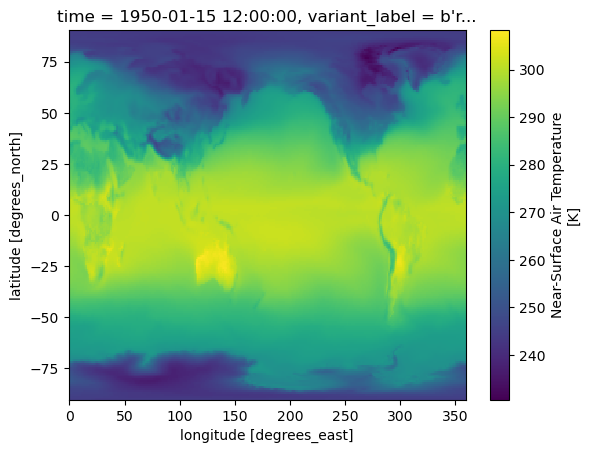

In [9]:
ds["tas"].sel(time='1950-01', variant_label=b"r9i1p1f1").squeeze().plot()

Create a timeseries of global-average surface air temperature. For this we need the area weighting factor for each gridpoint.

In [10]:
df.query("product == 'CMIP' & model == 'CESM2' & experiment == 'historical' & table == 'fx' & variable == 'areacella' & version == 'v20190311'")

,location,project,product,institution,model,experiment,subexperiment,table,variable,grid_label,version,replica
388899,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,CESM2,historical,NaN,fx,areacella,gn,v20190311,NaN
388903,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,CESM2,historical,NaN,fx,areacella,gn,v20190311,aims3.llnl.gov
388907,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,CESM2,historical,NaN,fx,areacella,gn,v20190311,esgf-data04.diasjp.net
388913,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,CESM2,historical,NaN,fx,areacella,gn,v20190311,esgf.nci.org.au
388915,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,CESM2,historical,NaN,fx,areacella,gn,v20190311,esgf3.dkrz.de


In [11]:
areacella = xarray.open_dataset(
    df.query("product == 'CMIP' & model == 'CESM2' & experiment == 'historical' & table == 'fx' & variable == 'areacella' & version == 'v20190311' & replica == 'esgf.nci.org.au'").iloc[0,0])
areacella

/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.Dataset> Size: 451kB
Dimensions:           (lat: 192, lon: 288, nbnd: 2, variant_label: 2,
                       nfiles: 2, file: 2)
Coordinates:
  * lat               (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon               (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * variant_label     (variant_label) |S64 128B b'r7i1p1f1' b'r9i1p1f1'
Dimensions without coordinates: nbnd, nfiles, file
Data variables:
    lat_bnds          (lat, nbnd) float32 2kB ...
    lon_bnds          (lon, nbnd) float32 2kB ...
    further_info_url  (nfiles, file) |S64 256B ...
    tracking_id       (nfiles, file) |S64 256B ...
    areacella         (variant_label, lat, lon) float32 442kB ...
Attributes: (12/51)
    Conventions:            
    activity_id:            CMIP
    case_id:                21
    cesm_casename:          b.e21.BHIST.f09_g17.CMIP6-historical.007
    contact:                cesm_cmip6@ucar.edu
    creation_date:          
    ...                     ...
    size_human:             85.5 KiB
    __info__:               Virtual dataset generated by the ESGF Virtual Agg...
    __license__:            This is a derived dataset product from ESGF, same...
    cmor_version:           
    version:                v20190311
    replica:                1

In [12]:
total_area = areacella["areacella"].sel(variant_label=b"r9i1p1f1").sum(dim=["lon", "lat"])
ta_timeseries = (ds["tas"].sel(variant_label=b"r9i1p1f1") * areacella["areacella"].sel(variant_label=b"r9i1p1f1")).sum(dim=["lon", "lat"]) / total_area
ta_timeseries

<xarray.DataArray (time: 1980)> Size: 8kB
dask.array<truediv, shape=(1980,), dtype=float32, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:0...
    variant_label  |S64 64B b'r9i1p1f1'

By default the data are loaded lazily, as [Dask arrays](https://docs.xarray.dev/en/stable/user-guide/dask.html). Here we trigger computation explicitly.

In [13]:
%time ta_timeseries.load()

CPU times: user 669 ms, sys: 1.51 s, total: 2.18 s
Wall time: 31.8 s


<xarray.DataArray (time: 1980)> Size: 8kB
array([285.6408 , 285.57397, 286.33856, ..., 288.6992 , 287.76303,
       287.0621 ], dtype=float32)
Coordinates:
  * time           (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:0...
    variant_label  |S64 64B b'r9i1p1f1'

Plot the result.

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

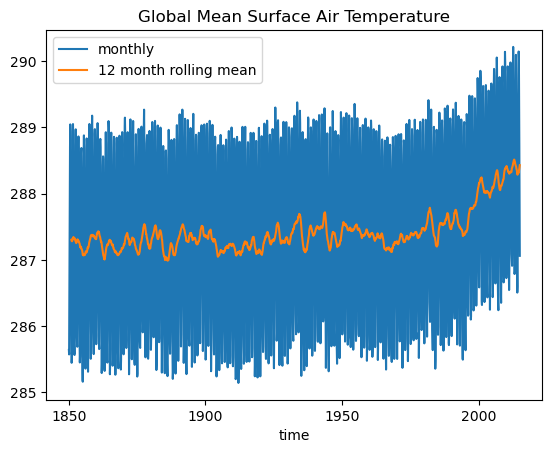

In [14]:
ta_timeseries.plot(label="monthly")
ta_timeseries.rolling(time=12).mean().plot(label="12 month rolling mean")
plt.legend()
plt.title("Global Mean Surface Air Temperature")

# Where to continue?

The ESGF-VA Science Gateway contains serveral notebooks that allow you to perform climata data analysis tasks. The following examples are available:

- [Calculating ENSO with Xarray and the ESGF Virtual Aggregation](enso.ipynb)
- [Generating Analysis Ready Cloud Optimized (ARCO) datasets](arco.ipynb)
- [Computing model member agreement](model-member-agreement.ipynb)
- [Computing evolution of global surface temperature for future scenarios](surface-temperature-scenarios.ipynb)